# Verifiers Evaluation Analysis

This notebook analyzes the evaluation results from the SWE-Grep OSS environment, focusing on the reward metrics defined in the rubric.


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

mkdir -p failed for path /home/ubuntu/.config/matplotlib: [Errno 13] Permission denied: '/home/ubuntu/.config/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-autq1gq8 because there was an issue with the default path (/home/ubuntu/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load Data

Load the evaluation results from the JSONL file.


In [2]:
# Define multiple result paths to compare
results_paths = [
    {
        "path": Path("../outputs/evals/swe-grep-oss-env--Qwen--Qwen3-8B/78b0c169/results.jsonl"),
        "label": "Sequential Tool Calls",
        "color": "#1f77b4"
    },
    {
        "path": Path("../outputs/evals/swe-grep-oss-env--Qwen--Qwen3-8B/d297f7fa/results.jsonl"),
        "label": "Parallel Tool Calls",
        "color": "#ff7f0e"
    },
    {
        "path": Path("../outputs/evals/swe-grep-oss-env--Qwen--Qwen3-8B/10097c89/results.jsonl"),
        "label": "Parallel Tool Calls (Bugs fixed)",
        "color": "#2ca02c"
    },
]

all_dfs = []
for result_config in results_paths:
    data = []
    with open(result_config["path"], "r") as f:
        for line in f:
            data.append(json.loads(line))
    
    df_temp = pd.DataFrame(data)
    df_temp["run_label"] = result_config["label"]
    df_temp["run_color"] = result_config["color"]
    all_dfs.append(df_temp)
    print(f"Loaded {len(data)} evaluation results from {result_config['label']}")

# Combine all dataframes
df = pd.concat(all_dfs, ignore_index=True)
print(f"\nTotal: {len(df)} evaluation results across {len(results_paths)} run(s)")
df.head()

Loaded 300 evaluation results from Sequential Tool Calls
Loaded 300 evaluation results from Parallel Tool Calls
Loaded 300 evaluation results from Parallel Tool Calls (Bugs fixed)

Total: 900 evaluation results across 3 run(s)


,example_id,prompt,completion,task,reward,generation_ms,scoring_ms,total_ms,info,answer,result_tool_check,result_tool_f1,result_tool_precision,result_tool_recall,tool_call_count,max_tokens_check,run_label,run_color
0,0,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,7.0,325858.666420,7.426739,325866.093159,"{'instance_id': 'astropy__astropy-12907', 'max...",diff --git a/astropy/modeling/separable.py b/a...,1.0,0.0,0.0,0.0,5.0,1.0,Sequential Tool Calls,#1f77b4
1,1,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,2.0,0.000000,7.534504,7.534504,"{'instance_id': 'astropy__astropy-14182', 'max...",diff --git a/astropy/io/ascii/rst.py b/astropy...,0.0,0.0,0.0,0.0,2.0,0.0,Sequential Tool Calls,#1f77b4
2,2,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,7.0,455875.408649,7.360458,455882.769108,"{'instance_id': 'astropy__astropy-14365', 'max...",diff --git a/astropy/io/ascii/qdp.py b/astropy...,1.0,0.0,0.0,0.0,5.0,1.0,Sequential Tool Calls,#1f77b4
3,3,[{'content': ' You are a helpful assistant tha...,"[{'content': ' <tool_call> {""name"": ""bash"", ""...",default,1.0,64561.590195,15.353203,64576.943398,"{'instance_id': 'astropy__astropy-14995', 'max...",diff --git a/astropy/nddata/mixins/ndarithmeti...,0.0,0.0,0.0,0.0,0.0,1.0,Sequential Tool Calls,#1f77b4
4,4,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,5.0,160655.382633,7.596493,160662.979126,"{'instance_id': 'astropy__astropy-6938', 'max_...",diff --git a/astropy/io/fits/fitsrec.py b/astr...,1.0,0.0,0.0,0.0,3.0,1.0,Sequential Tool Calls,#1f77b4


In [3]:
# Compute correct tool call metrics
def count_tool_calls(completion):
    """Count total tool calls across all messages in completion"""
    if not isinstance(completion, list):
        return 0
    
    total = 0
    for msg in completion:
        if isinstance(msg, dict) and msg.get('role') == 'assistant' and 'tool_calls' in msg:
            tool_calls = msg.get('tool_calls', [])
            if tool_calls:
                total += len(tool_calls)
    return total

def count_tool_calls_per_msg(completion):
    """Count average tool calls per message (only counting messages with tool calls)"""
    if not isinstance(completion, list):
        return 0.0
    
    total_calls = 0
    messages_with_calls = 0
    
    for msg in completion:
        if isinstance(msg, dict) and msg.get('role') == 'assistant' and 'tool_calls' in msg:
            tool_calls = msg.get('tool_calls', [])
            if tool_calls:
                total_calls += len(tool_calls)
                messages_with_calls += 1
    
    return total_calls / messages_with_calls if messages_with_calls > 0 else 0.0

# Apply the functions to create new columns
df['total_tool_calls'] = df['completion'].apply(count_tool_calls)
df['tool_calls_per_msg'] = df['completion'].apply(count_tool_calls_per_msg)

# Drop the old incorrect tool_call_count column
df = df.drop(columns=['tool_call_count'])

print(f"Added new columns: total_tool_calls, tool_calls_per_msg")
print(f"Removed old column: tool_call_count")
df[['total_tool_calls', 'tool_calls_per_msg']].describe()


Added new columns: total_tool_calls, tool_calls_per_msg
Removed old column: tool_call_count


,total_tool_calls,tool_calls_per_msg
count,900.000000,900.000000
mean,6.287778,1.636070
std,3.874342,0.793232
min,0.000000,0.000000
25%,4.000000,1.000000
50%,6.000000,1.333333
75%,8.000000,2.333333
max,29.000000,4.000000


## Reward Metrics Overview

The following reward metrics are defined in the rubric:

1. **result_tool_check**: Whether the result tool was called
2. **result_tool_f1**: F1 score of predicted file paths
3. **result_tool_precision**: Precision of predicted file paths
4. **result_tool_recall**: Recall of predicted file paths
5. **tool_call_count**: Number of tool calls made (normalized)
6. **max_tokens_check**: Whether token limit was exceeded


In [4]:
# Extract reward columns (removed tool_call_count, added new metrics)
reward_columns = [
    "result_tool_check",
    "result_tool_f1",
    "result_tool_precision",
    "result_tool_recall",
    "total_tool_calls",
    "tool_calls_per_msg",
    "max_tokens_check",
    "reward",
]

# Display basic statistics for each run
for run_label in df["run_label"].unique():
    print(f"\n{'='*60}")
    print(f"Statistics for: {run_label}")
    print('='*60)
    run_df = df[df["run_label"] == run_label]
    print(run_df[reward_columns].describe())
    print()


Statistics for: Sequential Tool Calls
       result_tool_check  result_tool_f1  result_tool_precision  \
count         300.000000      300.000000             300.000000   
mean            0.746667        0.199512               0.177336   
std             0.435647        0.356754               0.340640   
min             0.000000        0.000000               0.000000   
25%             0.000000        0.000000               0.000000   
50%             1.000000        0.000000               0.000000   
75%             1.000000        0.333333               0.200000   
max             1.000000        1.000000               1.000000   

       result_tool_recall  total_tool_calls  tool_calls_per_msg  \
count          300.000000        300.000000          300.000000   
mean             0.276667          6.326667            1.142520   
std              0.448098          3.467955            0.633949   
min              0.000000          0.000000            0.000000   
25%              0.000

## Distribution of Individual Rewards


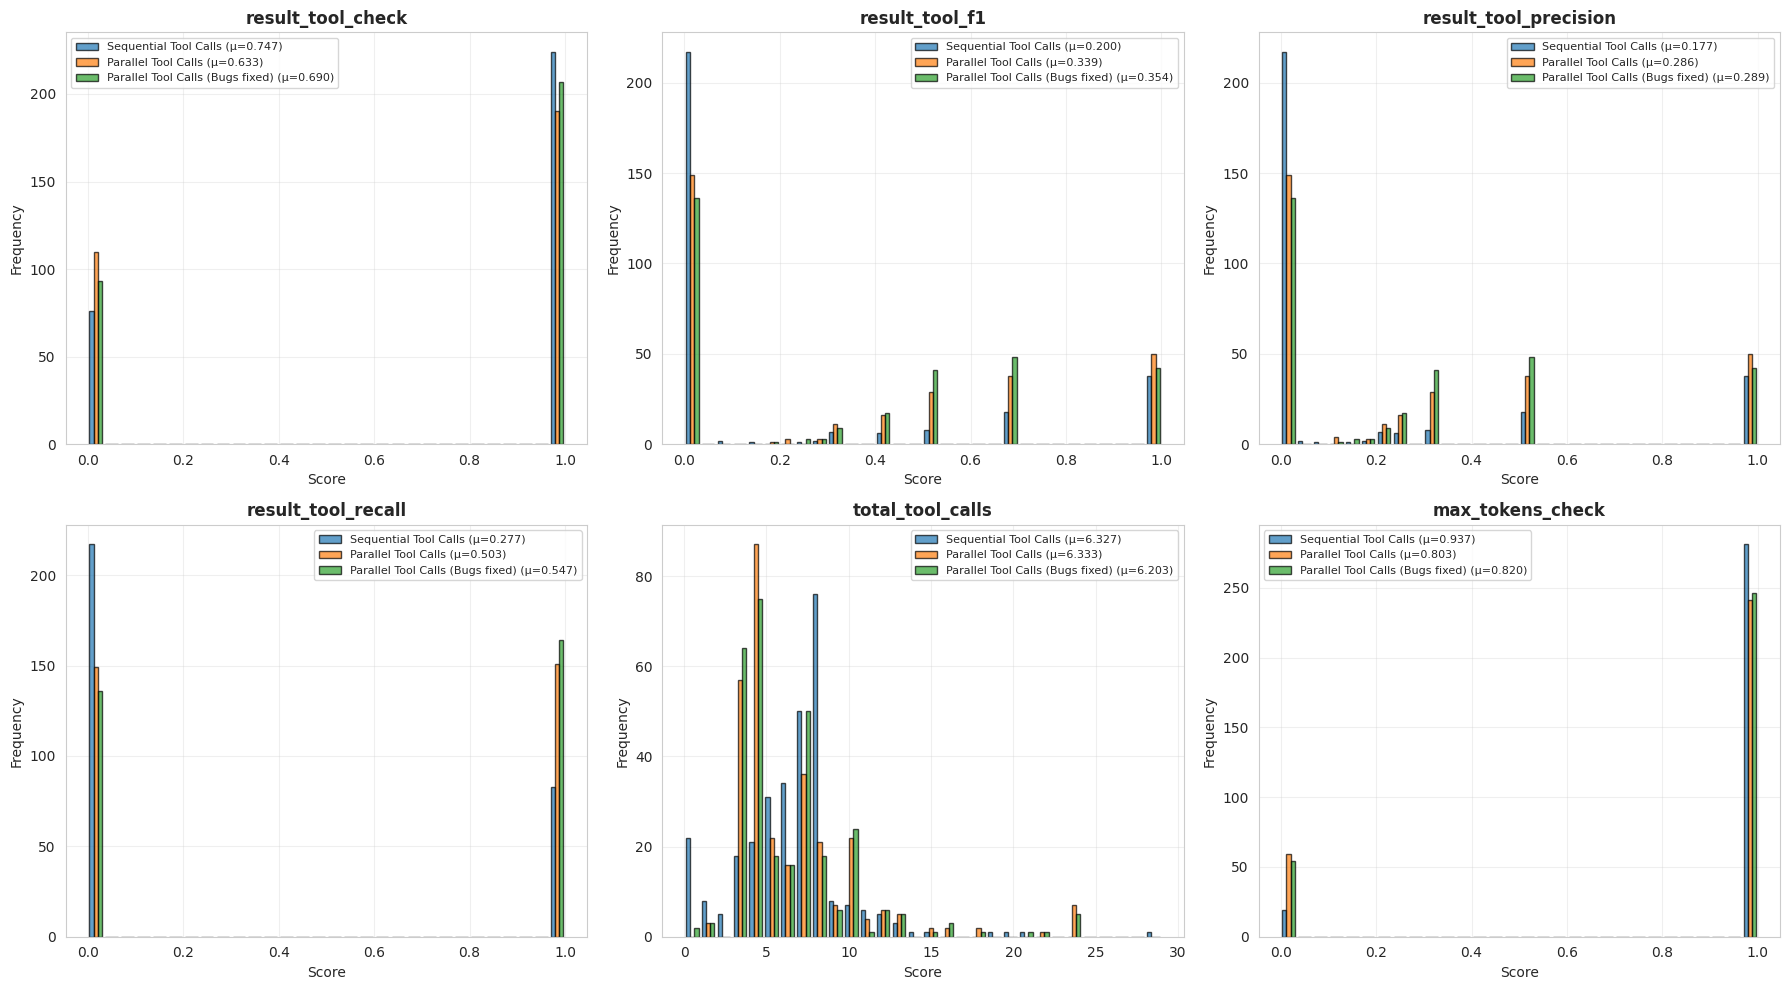

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

reward_metrics = [
    "result_tool_check",
    "result_tool_f1",
    "result_tool_precision",
    "result_tool_recall",
    "total_tool_calls",
    "max_tokens_check",
]

for idx, metric in enumerate(reward_metrics):
    ax = axes[idx]
    
    # Collect data for all runs first
    run_labels = df["run_label"].unique()
    all_data = []
    all_labels = []
    all_colors = []
    
    for run_label in run_labels:
        run_df = df[df["run_label"] == run_label]
        data_to_plot = run_df[metric].dropna()
        run_color = run_df["run_color"].iloc[0]
        
        all_data.append(data_to_plot)
        all_labels.append(f"{run_label} (μ={data_to_plot.mean():.3f})")
        all_colors.append(run_color)
    
    # Create histogram with bars side by side
    ax.hist(
        all_data,
        bins=30,
        edgecolor="black",
        alpha=0.7,
        label=all_labels,
        color=all_colors
    )
    
    ax.set_title(f"{metric}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

## Overall Performance Metrics

Aggregate metrics across all evaluation instances:


OVERALL PERFORMANCE METRICS - Sequential Tool Calls
Accuracy (Result Tool Called) : 0.7467 (74.67%)
F1 Score                      : 0.1995 (19.95%)
Precision                     : 0.1773 (17.73%)
Recall                        : 0.2767 (27.67%)

OVERALL PERFORMANCE METRICS - Parallel Tool Calls
Accuracy (Result Tool Called) : 0.6333 (63.33%)
F1 Score                      : 0.3387 (33.87%)
Precision                     : 0.2861 (28.61%)
Recall                        : 0.5033 (50.33%)

OVERALL PERFORMANCE METRICS - Parallel Tool Calls (Bugs fixed)
Accuracy (Result Tool Called) : 0.6900 (69.00%)
F1 Score                      : 0.3536 (35.36%)
Precision                     : 0.2892 (28.92%)
Recall                        : 0.5467 (54.67%)



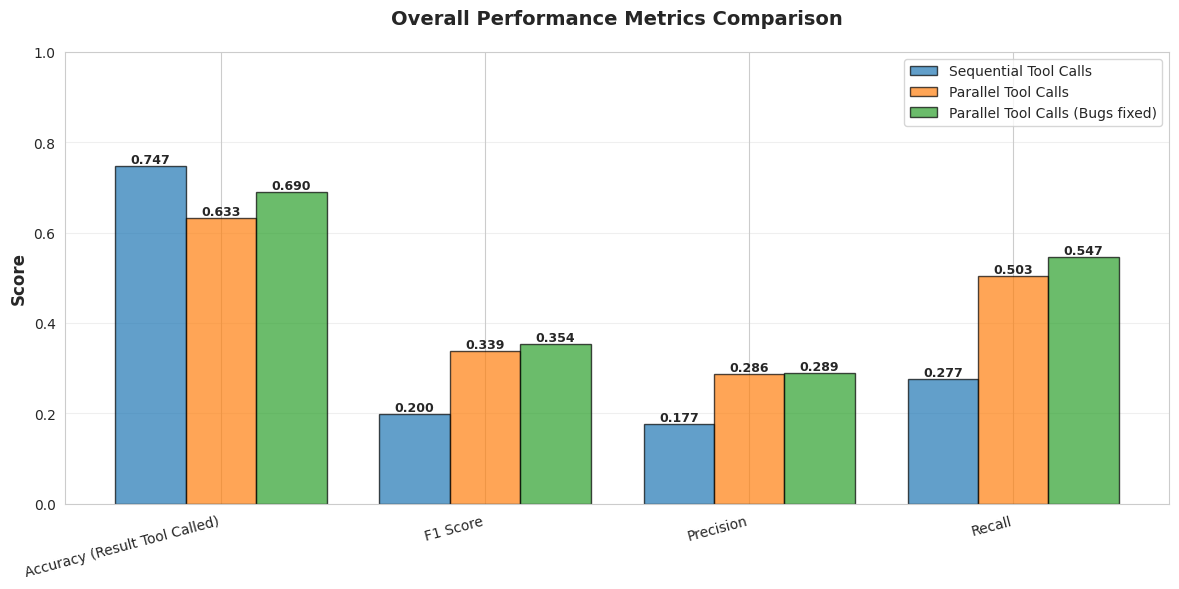

In [6]:
# Calculate overall metrics for each run
metric_names = [
    "Accuracy (Result Tool Called)",
    "F1 Score",
    "Precision",
    "Recall",
]

metric_columns = [
    "result_tool_check",
    "result_tool_f1",
    "result_tool_precision",
    "result_tool_recall",
]

# Display as a formatted table
for run_label in df["run_label"].unique():
    run_df = df[df["run_label"] == run_label]
    overall_metrics = {
        name: run_df[col].mean()
        for name, col in zip(metric_names, metric_columns)
    }
    
    print("=" * 60)
    print(f"OVERALL PERFORMANCE METRICS - {run_label}")
    print("=" * 60)
    for metric_name, value in overall_metrics.items():
        print(f"{metric_name:30s}: {value:.4f} ({value*100:.2f}%)")
    print("=" * 60)
    print()

# Create a grouped bar chart comparing all runs
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metric_names))
width = 0.8 / len(df["run_label"].unique())  # Dynamic width based on number of runs

for idx, run_label in enumerate(df["run_label"].unique()):
    run_df = df[df["run_label"] == run_label]
    run_color = run_df["run_color"].iloc[0]
    
    metrics_values = [
        run_df[col].mean() for col in metric_columns
    ]
    
    offset = (idx - len(df["run_label"].unique())/2 + 0.5) * width
    bars = ax.bar(
        x + offset,
        metrics_values,
        width,
        label=run_label,
        color=run_color,
        alpha=0.7,
        edgecolor="black",
    )
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title(
    "Overall Performance Metrics Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(fontsize=10, loc='upper right')
ax.set_ylim(0, 1.0)  # Fixed scale for comparison
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

## Tool Call Analysis

Distribution of tool calls and errors per instance:


TOOL CALL & RESPONSE STATISTICS - Sequential Tool Calls
Tool calls made:       mean=6.33, median=7, max=29
Tool calls per msg:    mean=1.14
Tool responses:        mean=5.88, median=6, max=28
Error responses:       mean=1.45, median=1, max=9
Error percentage:      mean=21.16%

TOOL CALL & RESPONSE STATISTICS - Parallel Tool Calls
Tool calls made:       mean=6.33, median=5, max=24
Tool calls per msg:    mean=1.86
Tool responses:        mean=6.14, median=5, max=21
Error responses:       mean=0.97, median=0, max=16
Error percentage:      mean=10.78%

TOOL CALL & RESPONSE STATISTICS - Parallel Tool Calls (Bugs fixed)
Tool calls made:       mean=6.20, median=5, max=24
Tool calls per msg:    mean=1.90
Tool responses:        mean=6.08, median=5, max=21
Error responses:       mean=0.69, median=0, max=19
Error percentage:      mean=7.48%



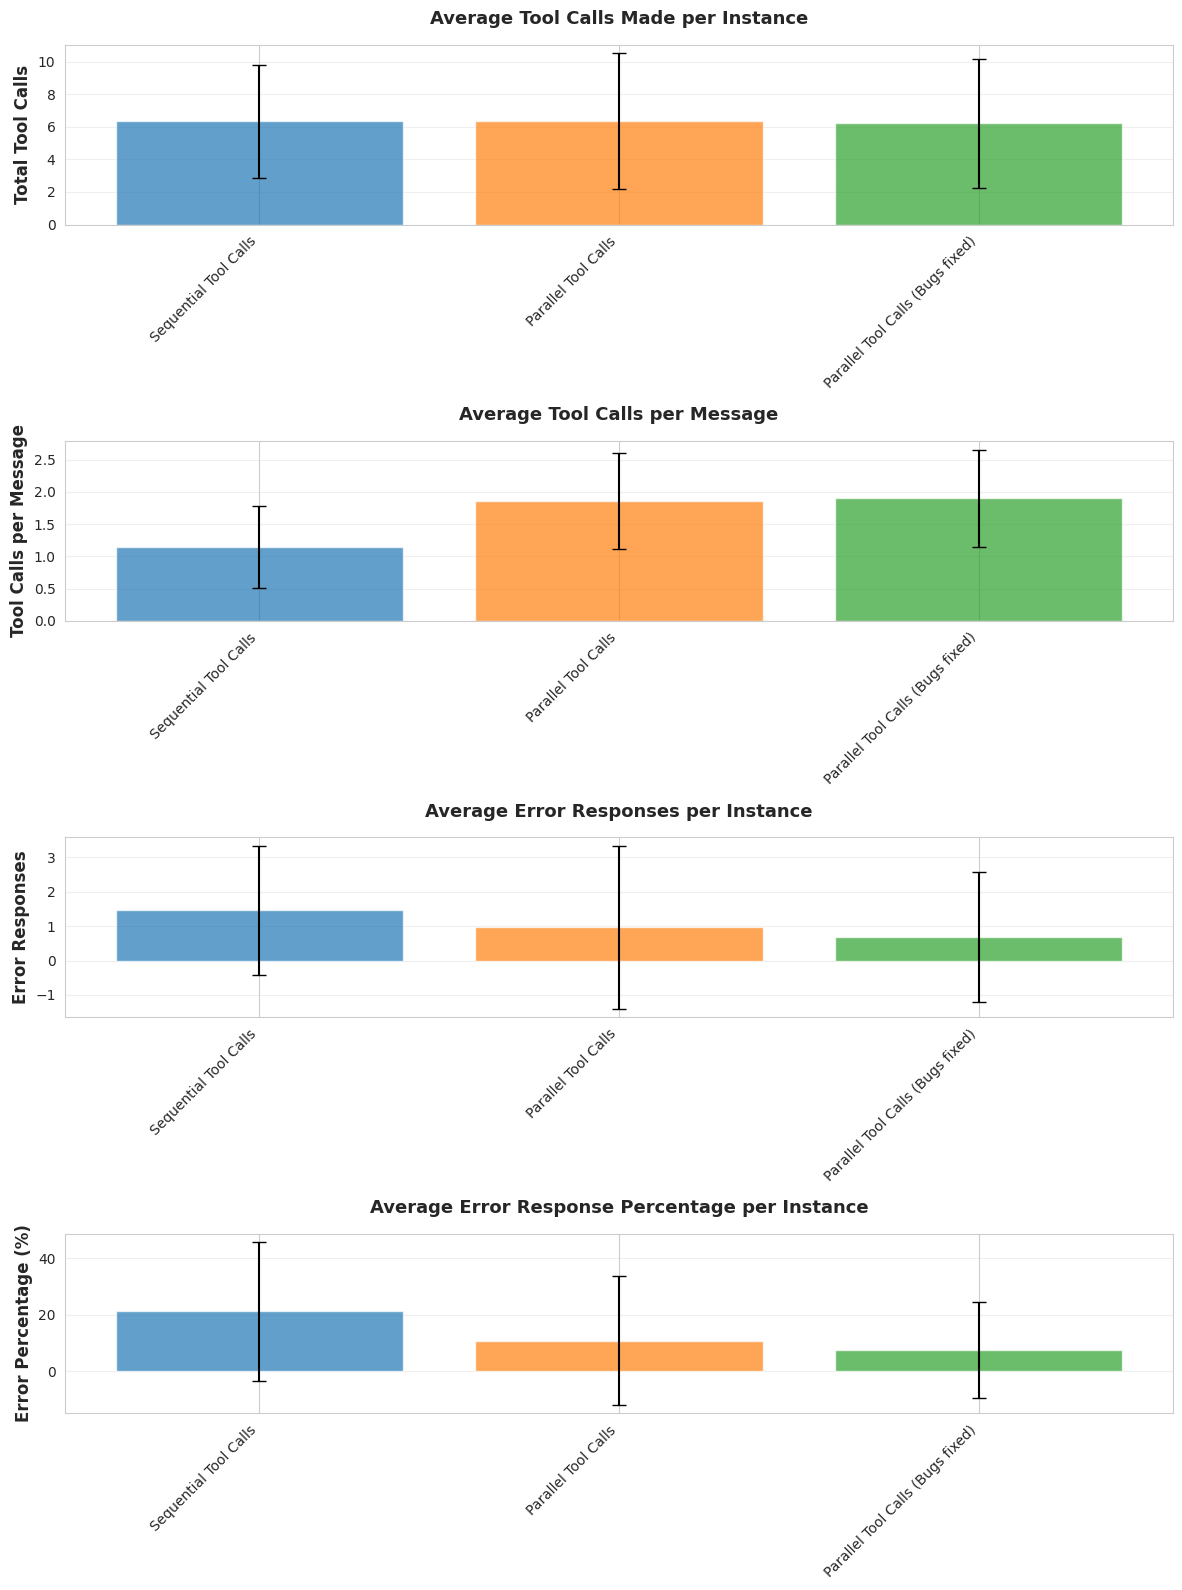

In [7]:
# Count tool response messages (role="tool") for each instance
tool_response_counts = []
error_response_counts = []
error_response_percentages = []

for idx, row in df.iterrows():
    completion = row["completion"]
    total_responses = 0
    error_responses = 0

    for message in completion:
        if message.get("role") == "tool":
            total_responses += 1
            content = message.get("content", "")
            if content.startswith("Error"):
                error_responses += 1

    tool_response_counts.append(total_responses)
    error_response_counts.append(error_responses)
    error_percentage = (
        (error_responses / total_responses * 100) if total_responses > 0 else 0
    )
    error_response_percentages.append(error_percentage)

# Add to dataframe
df["tool_response_count"] = tool_response_counts
df["error_response_count"] = error_response_counts
df["error_response_percentage"] = error_response_percentages

# Display summary statistics for each run
for run_label in df["run_label"].unique():
    run_df = df[df["run_label"] == run_label]
    
    print("=" * 60)
    print(f"TOOL CALL & RESPONSE STATISTICS - {run_label}")
    print("=" * 60)
    print(f"Tool calls made:       mean={run_df['total_tool_calls'].mean():.2f}, "
          f"median={run_df['total_tool_calls'].median():.0f}, "
          f"max={run_df['total_tool_calls'].max():.0f}")
    print(f"Tool calls per msg:    mean={run_df['tool_calls_per_msg'].mean():.2f}")
    print(f"Tool responses:        mean={run_df['tool_response_count'].mean():.2f}, "
          f"median={run_df['tool_response_count'].median():.0f}, "
          f"max={run_df['tool_response_count'].max():.0f}")
    print(f"Error responses:       mean={run_df['error_response_count'].mean():.2f}, "
          f"median={run_df['error_response_count'].median():.0f}, "
          f"max={run_df['error_response_count'].max():.0f}")
    print(f"Error percentage:      mean={run_df['error_response_percentage'].mean():.2f}%")
    print("=" * 60)
    print()

# Visualize with simple bar charts
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

run_labels = df["run_label"].unique()
x_pos = np.arange(len(run_labels))
colors = [df[df["run_label"] == run_label]["run_color"].iloc[0] for run_label in run_labels]

# 1. Total tool calls per instance
ax1 = axes[0]
means = [df[df["run_label"] == run_label]["total_tool_calls"].mean() for run_label in run_labels]
stds = [df[df["run_label"] == run_label]["total_tool_calls"].std() for run_label in run_labels]

ax1.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(run_labels, rotation=45, ha='right')
ax1.set_ylabel("Total Tool Calls", fontsize=12, fontweight="bold")
ax1.set_title("Average Tool Calls Made per Instance", fontsize=13, fontweight="bold", pad=15)
ax1.grid(True, alpha=0.3, axis="y")

# 2. Tool calls per message
ax2 = axes[1]
means = [df[df["run_label"] == run_label]["tool_calls_per_msg"].mean() for run_label in run_labels]
stds = [df[df["run_label"] == run_label]["tool_calls_per_msg"].std() for run_label in run_labels]

ax2.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(run_labels, rotation=45, ha='right')
ax2.set_ylabel("Tool Calls per Message", fontsize=12, fontweight="bold")
ax2.set_title("Average Tool Calls per Message", fontsize=13, fontweight="bold", pad=15)
ax2.grid(True, alpha=0.3, axis="y")

# 3. Error responses per instance
ax3 = axes[2]
means = [df[df["run_label"] == run_label]["error_response_count"].mean() for run_label in run_labels]
stds = [df[df["run_label"] == run_label]["error_response_count"].std() for run_label in run_labels]

ax3.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(run_labels, rotation=45, ha='right')
ax3.set_ylabel("Error Responses", fontsize=12, fontweight="bold")
ax3.set_title("Average Error Responses per Instance", fontsize=13, fontweight="bold", pad=15)
ax3.grid(True, alpha=0.3, axis="y")

# 4. Error percentage per instance
ax4 = axes[3]
means = [df[df["run_label"] == run_label]["error_response_percentage"].mean() for run_label in run_labels]
stds = [df[df["run_label"] == run_label]["error_response_percentage"].std() for run_label in run_labels]

ax4.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, capsize=5)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(run_labels, rotation=45, ha='right')
ax4.set_ylabel("Error Percentage (%)", fontsize=12, fontweight="bold")
ax4.set_title("Average Error Response Percentage per Instance", fontsize=13, fontweight="bold", pad=15)
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()